### Face Recognition of Planview employees

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
BASE = 'data/sample-3'

In [4]:
ls {BASE}

models/ test/   train/  valid/


In [7]:
PATH = 'data/sample-3/'

In [8]:
files = !ls {PATH}train/gagan
files

['gagan 2.jpeg', 'gagan.jpeg']

In [10]:
files = !ls {PATH}valid/gagan
files

['IMG_1673.jpeg']

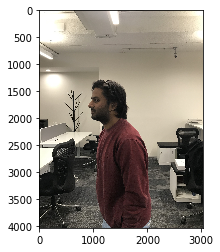

In [11]:
img = plt.imread(f'{PATH}valid/gagan/{files[0]}')
plt.imshow(img);

In [9]:
# Uncomment the below if you need to reset your precomputed activations
#!rm -rf {PATH}tmp

In [12]:
sz =224
#arch=resnet152
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.1, 10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/gagan/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:16<00:00, 5237451.63it/s] 


100%|██████████| 1/1 [00:11<00:00, 11.66s/it]


epoch      trn_loss   val_loss   accuracy        
    0      2.6992     2.515322   0.285714  
    1      2.099896   2.375985   0.285714        
    2      1.606249   2.460906   0.285714        
    3      1.236353   2.59856    0.333333        
    4      1.006041   2.819422   0.380952        
    5      0.84403    2.988864   0.428571        
    6      0.726319   2.994535   0.428571        
    7      0.633348   3.000711   0.428571        
    8      0.560744   3.032207   0.428571        
    9      0.502719   3.061061   0.428571        



[3.061061382293701, 0.4285714328289032]

In [13]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 6, 6, 6, 6, 7, 8, 9, 9])

In [14]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['appa',
 'gagan',
 'joe',
 'krishna',
 'lawrence',
 'ramana',
 'rithwik',
 'som',
 'sudheera',
 'vinayak']

In [15]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(21, 10)

In [16]:
log_preds[:2]

array([[ -0.02096,  -8.5043 ,  -4.44996,  -6.00905,  -8.87311,  -8.61431, -10.61584,  -5.11938,  -9.64841,
        -11.22354],
       [ -0.00467,  -9.17881,  -5.9876 ,  -9.30909, -10.15592,  -7.15939, -12.84922,  -6.79776, -11.05968,
        -12.03349]], dtype=float32)

In [17]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [18]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [19]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [20]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [21]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

Correctly classified


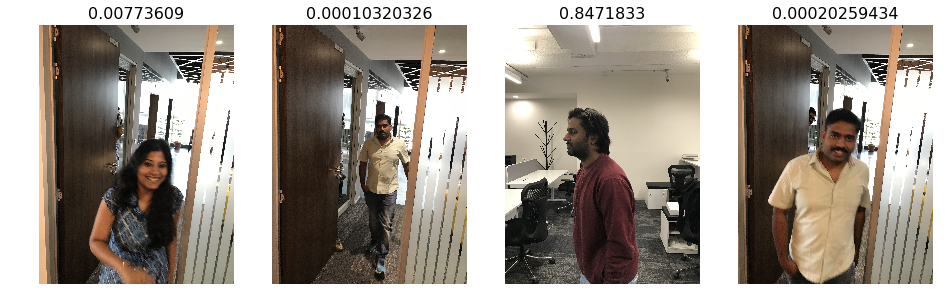

In [22]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


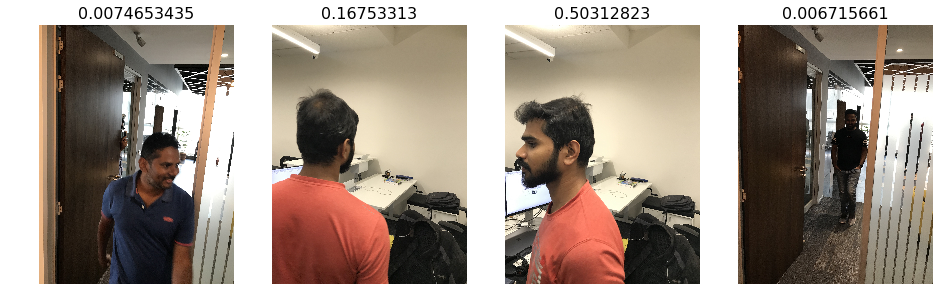

In [23]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [24]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [25]:
#Mistake! Correct this 
#plot_val_with_title(most_by_correct(0, True), "Most correct Alejandro_Toledo") # 0 ->  Alejandro_Toledo

In [26]:
#plot_val_with_title(most_by_correct(15, True), "Most correct Alejandro_Toledo") # 0 ->  Alejandro_Toledo

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy        
    0      2.750475   3.265028   0.095238  



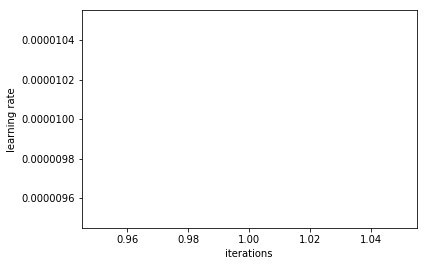

In [29]:
learn.sched.plot_lr()

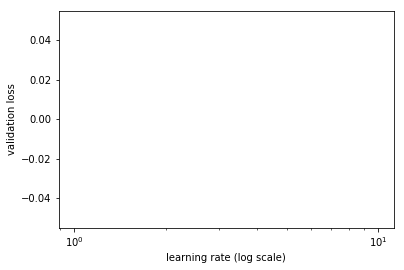

In [30]:
learn.sched.plot()

In [31]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [32]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [33]:
ims = np.stack([get_augs() for i in range(6)])

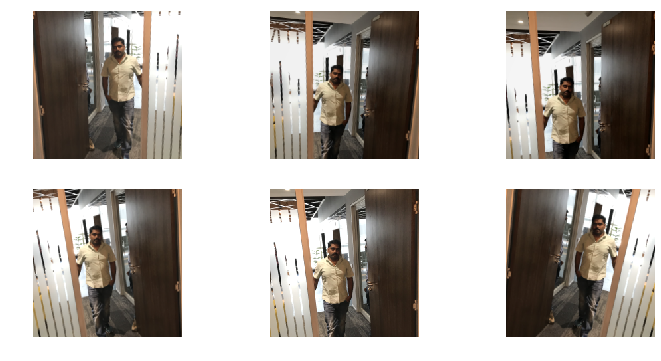

In [34]:
plots(ims, rows=2)

In [35]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True,ps=0.5)

In [36]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy        
    0      2.575506   2.850078   0.095238  



[2.8500778675079346, 0.095238097012043]

In [37]:
learn.precompute=False

In [38]:
%time learn.fit(1e-1, 10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      3.082289   2.679211   0.142857  
    1      2.853243   2.57778    0.142857                
    2      2.849347   2.171958   0.380952                
    3      2.482001   2.131824   0.380952                
    4      2.27793    2.143718   0.380952                
    5      2.097943   2.130408   0.380952                
    6      1.879422   2.358904   0.380952                
    7      1.700492   2.3331     0.380952                
    8      1.552993   2.52857    0.52381                 
    9      1.428409   2.462745   0.52381                 

CPU times: user 9min 21s, sys: 4min 34s, total: 13min 55s
Wall time: 5min 23s


[2.462745189666748, 0.523809552192688]

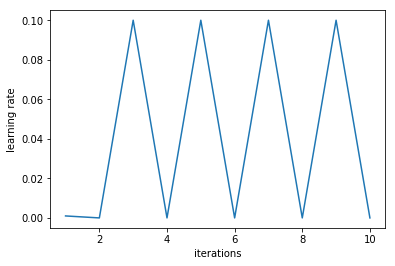

In [39]:
learn.sched.plot_lr()

In [40]:
learn.unfreeze()

In [41]:
learn.freeze_to(1)
lr=np.array([1e-4,1e-4, 2e-2])

In [ ]:
%time learn.fit(lr, 7, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.821015   2.424685   0.52381   
    1      0.770597   2.402133   0.52381                 
    2      0.751138   2.400428   0.52381                 
    3      0.692542   2.374398   0.47619                 
    4      0.712096   2.344699   0.52381                 
    5      0.674187   2.315099   0.52381                 
    6      0.646761   2.329804   0.52381                 
    7      0.661671   2.308217   0.52381                 
    8      0.620028   2.322299   0.52381                 
    9      0.582819   2.310598   0.52381                 
    10     0.561281   2.324204   0.52381                 
    11     0.539913   2.311121   0.52381                 
    12     0.52584    2.322957   0.52381                 
    13     0.497488   2.314      0.52381                 
    14     0.476915   2.317774   0.571429                
    15     0.457767   2.328028   0.52381                 
    16     0.442319   2.3363

In [ ]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

### End